In [1]:
# ======================
# Import library
# ======================
import tensorflow as tf
from tensorflow.keras import layers, models
import os, json, time, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc
)
from sklearn.utils import class_weight
from sklearn.preprocessing import label_binarize
import seaborn as sns

In [2]:
# ======================
# Konfigurasi
# ======================
IMG_SIZE = (224, 224)
BATCH = 32
EPOCHS = 30
ANNOTATION_JSON = "augmented_output/annotations.json"

DATASET_DIR = "dataset_classification"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "valid")
TEST_DIR = os.path.join(DATASET_DIR, "test")

In [3]:
# ======================
# Augmentasi runtime
# ======================
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name="augment")

In [4]:
# ======================
# Load dataset real (folder)
# ======================
train_ds_real = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH, label_mode='categorical', shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR, image_size=IMG_SIZE, batch_size=BATCH, label_mode='categorical', shuffle=False
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH, label_mode='categorical', shuffle=False
)

class_names = train_ds_real.class_names
NUM_CLASSES = len(class_names)
class_to_idx = {cls: i for i, cls in enumerate(class_names)}
print(f"Kelas yang terdeteksi: {class_names}")

Found 987 files belonging to 2 classes.
Found 104 files belonging to 2 classes.
Found 42 files belonging to 2 classes.
Kelas yang terdeteksi: ['Ganoderma', 'Sehat']


In [5]:
# ======================
# Load dataset augmentasi dari JSON (augmented_output)
# ======================
image_paths, labels_idx = [], []
if os.path.exists(ANNOTATION_JSON):
    with open(ANNOTATION_JSON, "r") as f:
        ann = json.load(f)
    for item in ann:
        cls = item.get("class")
        if cls not in class_to_idx:
            continue
        idx = class_to_idx[cls]
        orig, aug = item.get("original"), item.get("augmented")
        if orig and os.path.exists(orig):
            image_paths.append(orig)
            labels_idx.append(idx)
        if aug and os.path.exists(aug):
            image_paths.append(aug)
            labels_idx.append(idx)
    print(f"Total augmented images loaded dari JSON: {len(image_paths)}")
else:
    print("⚠️ File annotations.json tidak ditemukan di augmented_output. Tidak ada augmentasi file yang ditambahkan.")


Total augmented images loaded dari JSON: 1974


In [6]:
# ======================
# Preprocessing path+label untuk aug_ds
# ======================
def preprocess_path_label(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    # normalisasi optional: img = img / 255.0
    return img, tf.one_hot(label, NUM_CLASSES)

In [7]:
# ======================
# Buat aug_ds jika ada
# ======================
if len(image_paths) > 0:
    aug_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels_idx))
    aug_ds = aug_ds.shuffle(len(image_paths))
    aug_ds = aug_ds.map(preprocess_path_label, num_parallel_calls=tf.data.AUTOTUNE)
    aug_ds = aug_ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
else:
    aug_ds = None

In [8]:
# ======================
# Gabungkan dataset real + augmentasi-file (jika ada)
# ======================
if aug_ds:
    # note: train_ds_real sudah batch-ed, aug_ds sudah batch-ed
    # untuk keamanan, kita ambil train_ds_real tanpa batching (recreate) agar concatenate konsisten
    train_ds_real_unbatched = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR, image_size=IMG_SIZE, batch_size=1, label_mode='categorical', shuffle=True
    ).map(lambda x,y: (tf.squeeze(x, axis=0), tf.squeeze(y, axis=0)))  # ubah jadi unbatched
    # buat aug unbatched juga (karena sudah batch sebelumnya, kita ulangi pipeline)
    aug_ds_unbatched = tf.data.Dataset.from_tensor_slices((image_paths, labels_idx))
    aug_ds_unbatched = aug_ds_unbatched.shuffle(len(image_paths))
    aug_ds_unbatched = aug_ds_unbatched.map(preprocess_path_label, num_parallel_calls=tf.data.AUTOTUNE)
    # sekarang concat unbatched, lalu batch setelah augmentasi runtime diterapkan
    combined_unbatched = train_ds_real_unbatched.concatenate(aug_ds_unbatched)
    # Terapkan augmentasi runtime di sini (masih unbatched)
    combined_unbatched = combined_unbatched.map(lambda x, y: (data_aug(tf.expand_dims(x,0), training=True)[0], y),
                                                num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = combined_unbatched.batch(BATCH).prefetch(tf.data.AUTOTUNE)
else:
    # cukup pakai train_ds_real dan terapkan augmentasi runtime
    train_ds = train_ds_real.map(lambda x, y: (data_aug(x, training=True), y))
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# Pastikan val & test prefetch
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

print("✅ Dataset (real + optional augment-file + runtime-augment) siap untuk training")

Found 987 files belonging to 2 classes.
✅ Dataset (real + optional augment-file + runtime-augment) siap untuk training


In [9]:
# ======================
# Hitung class weights berdasarkan train_ds_real (tanpa aug-file)
# ======================
y_train = []
for _, labels in train_ds_real:
    y_train.extend(np.argmax(labels.numpy(), axis=1))
y_train = np.array(y_train)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.8225), 1: np.float64(1.2751937984496124)}


In [10]:
# ======================
# Definisi model CNN + Softmax + Dropout
# ======================
def build_model():
    model = models.Sequential([
        layers.Input(shape=(*IMG_SIZE,3)),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,690 (49.36 MB)

 Trainable params: 12,938,690 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# ======================
# Training
# ======================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights
)

# model.save("model_cnn_softmax_dropout_augfile.h5")
print("✅ Training selesai dan model tersimpan")

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 68s 698ms/step - accuracy: 0.5578 - loss: 451.5443 - val_accuracy: 0.5481 - val_loss: 0.6922
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 62s 661ms/step - accuracy: 0.4816 - loss: 0.7057 - val_accuracy: 0.4038 - val_loss: 0.6939
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 60s 640ms/step - accuracy: 0.4883 - loss: 0.6969 - val_accuracy: 0.3846 - val_loss: 0.6946
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 713ms/step - accuracy: 0.5082 - loss: 0.6933 - val_accuracy: 0.3942 - val_loss: 0.6989
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 60s 640ms/step - accuracy: 0.4650 - loss: 0.7031 - val_accuracy: 0.3750 - val_loss: 0.6951
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 61s 651ms/step - accuracy: 0.4610 - loss: 0.7066 - val_accuracy: 0.4038 - val_loss: 0.6942
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 62s 660ms/step - accuracy: 0.4767 - loss: 0.6996 - val_accuracy: 0.3942 - val_loss: 0.6954
Epoch 8/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 59s 628ms/step - accuracy: 0.4725 - loss: 0.6989 - val_ac

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step

=== Evaluation Metrics ===
Accuracy  : 0.3810
Precision : 0.1451
Recall    : 0.3810
F1-Score  : 0.2102
Loss      : 0.6938
Rata-rata waktu inferensi per gambar: 0.0343 detik


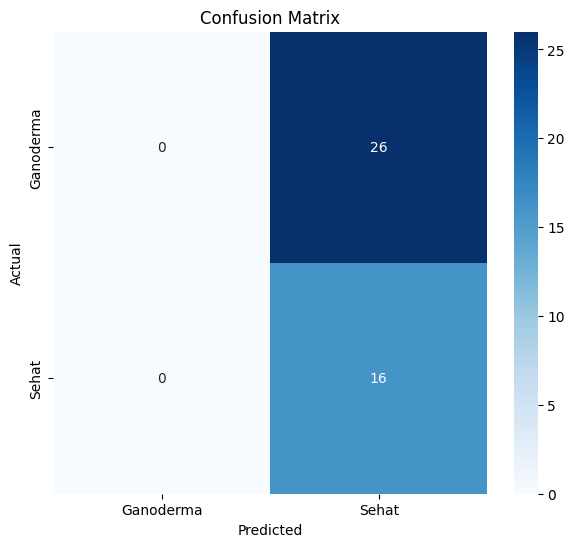

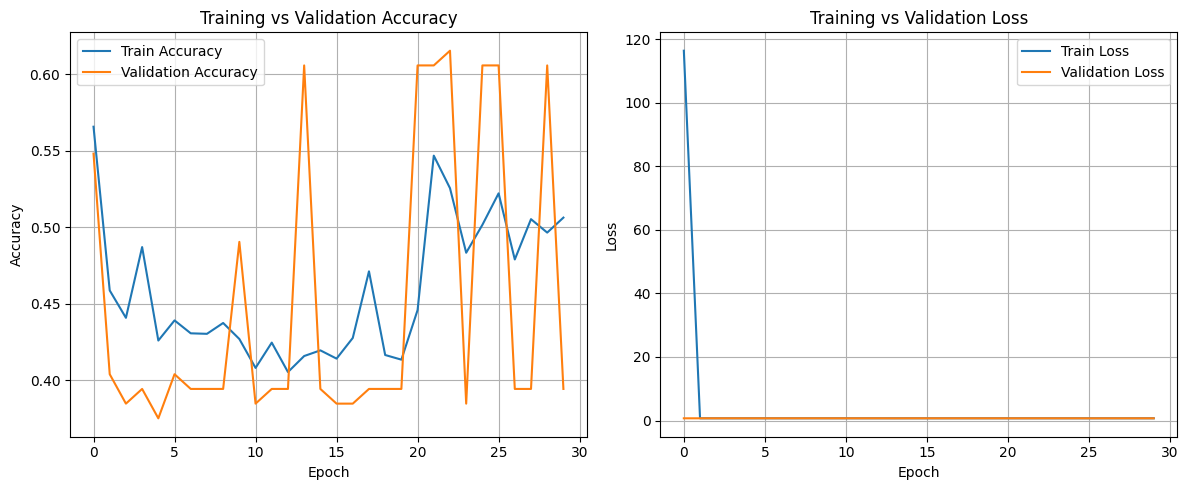

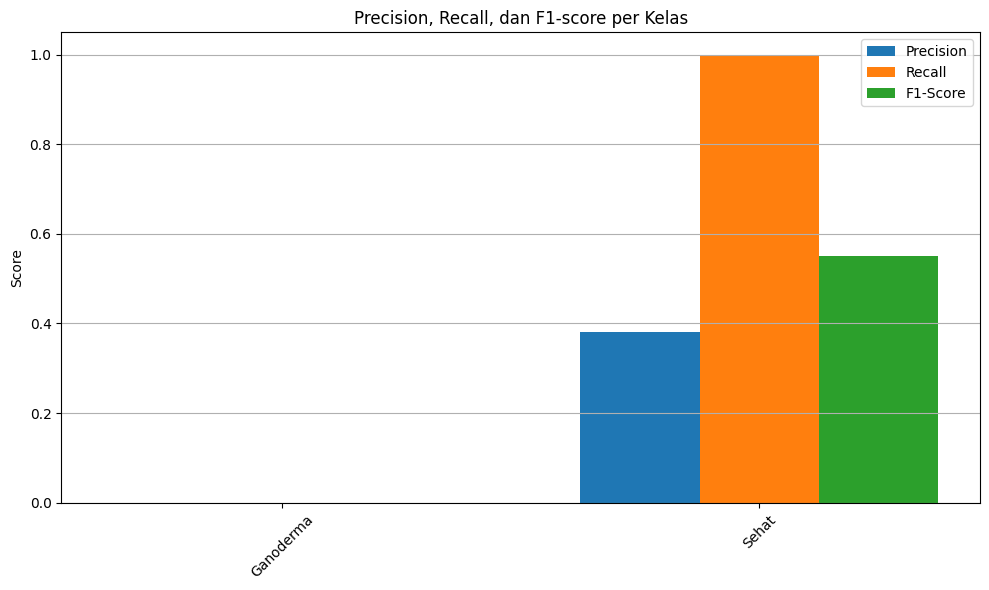

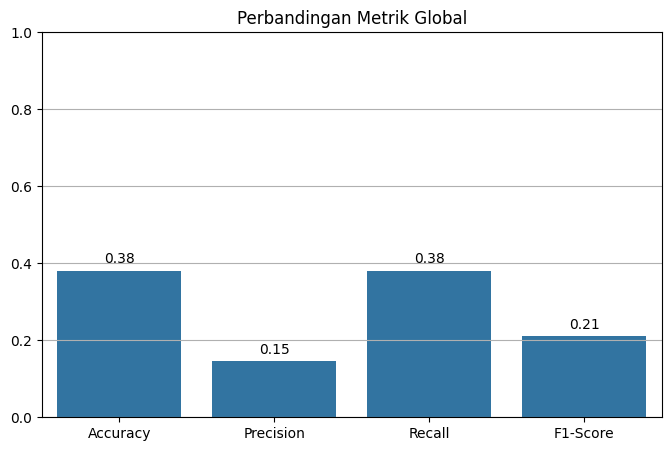

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


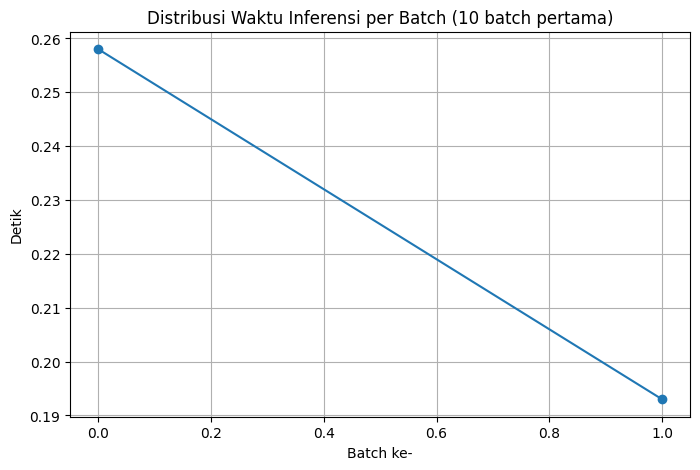


=== Classification Report ===
              precision    recall  f1-score   support

   Ganoderma       0.00      0.00      0.00        26
       Sehat       0.38      1.00      0.55        16

    accuracy                           0.38        42
   macro avg       0.19      0.50      0.28        42
weighted avg       0.15      0.38      0.21        42



In [12]:
# ======================
# Evaluasi (lengkap + grafik)
# ======================
y_true, y_pred, y_prob = [], [], []
start_time = time.time()
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    y_prob.extend(preds)
end_time = time.time()
inference_time = (end_time - start_time) / len(y_true)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
test_loss, test_acc = model.evaluate(test_ds, verbose=0)

print("\n=== Evaluation Metrics ===")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-Score  : {f1:.4f}")
print(f"Loss      : {test_loss:.4f}")
print(f"Rata-rata waktu inferensi per gambar: {inference_time:.4f} detik")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Training History (Accuracy & Loss)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision / Recall / F1 per kelas
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
precisions = [report[c]['precision'] for c in class_names]
recalls = [report[c]['recall'] for c in class_names]
f1s = [report[c]['f1-score'] for c in class_names]

x = np.arange(len(class_names))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, precisions, width, label='Precision')
plt.bar(x, recalls, width, label='Recall')
plt.bar(x + width, f1s, width, label='F1-Score')
plt.xticks(x, class_names, rotation=45)
plt.ylabel("Score")
plt.title("Precision, Recall, dan F1-score per Kelas")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# ROC Curve (macro average)
if NUM_CLASSES > 2:
    y_true_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= NUM_CLASSES

    plt.figure(figsize=(7,6))
    plt.plot(all_fpr, mean_tpr, color='blue', lw=2, label=f'Macro-average ROC (AUC = {np.mean(list(roc_auc.values())):.4f})')
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Macro-average ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Perbandingan Global Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [acc, prec, rec, f1]
plt.figure(figsize=(8,5))
sns.barplot(x=metrics, y=values)
plt.title("Perbandingan Metrik Global")
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.grid(True, axis='y')
plt.show()

# Distribusi waktu inferensi per batch
batch_times = []
for images, labels in test_ds.take(10):
    start = time.time()
    _ = model.predict(images)
    end = time.time()
    batch_times.append(end - start)

plt.figure(figsize=(8,5))
plt.plot(batch_times, marker='o')
plt.title("Distribusi Waktu Inferensi per Batch (10 batch pertama)")
plt.xlabel("Batch ke-")
plt.ylabel("Detik")
plt.grid(True)
plt.show()

# Classification Report lengkap
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))